## making test plots

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [9]:
from functions import ccplot, binning

In [10]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [11]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

In [12]:
mfdata_DIR = './data/GPM_lowres_data/*.nc'

gpm = xr.open_mfdataset(mfdata_DIR, chunks=dict(time=8000, lat=40, lon=40), engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_mfdataset(mfdata_DIR, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_data/gpm_2000.nc', chunks={"time":2000})

In [13]:
gpm = gpm.unify_chunks()
gpm.chunks

Frozen({'time': (8000, 2272, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1568, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1568, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1568, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1568, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1520, 8000, 8000, 1568, 8000, 688), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [14]:
mfdata_DIR2 = './data/era_data/*.nc'

era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=8000, lat=40, lon=40), engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [15]:
era = era.unify_chunks()
era.chunks

Frozen({'time': (8000, 784, 8000, 760, 8000, 760, 8000, 760, 8000, 784, 8000, 760, 8000, 760, 8000, 760, 8000, 784, 8000, 760, 8000, 760, 8000, 760, 8000, 784, 8000, 760, 8000, 760, 8000, 760, 8000, 784, 8000, 760, 8000, 760, 8000, 760, 8000, 784, 6775), 'latitude': (161,), 'longitude': (161,), 'expver': (2,)})

In [16]:
era = era.sel(expver=1, drop=True)

In [17]:
era = era.transpose('time', 'latitude', 'longitude')
era = era.rename({'longitude':'lon', 'latitude':'lat'})
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))

In [33]:
def plot(da, extent_list, title=None, **kwargs):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent_list, crs=ccrs.PlateCarree())
    da.plot.contourf(ax = ax, **kwargs)
    gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
    # ax.coastlines(alpha=0.7)
    # ax.add_feature(cfeature.BORDERS, alpha=0.7)
    ax.add_feature(cfeature.COASTLINE, alpha=1.0)
    gridliner.top_labels = False
    gridliner.right_labels = False
    gridliner.ylines = False  # you need False
    gridliner.xlines = False  # you need False
    if title != None:
        ax.set_title(title)
    # ax.set_xlabel('Longitude')
    # ax.set_ylabel('Latitude')
#     ax.tick_params(axis='both', labelsize=12)

In [23]:
era_mean = era.mean(dim='time').compute()

/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [35]:
t2m_anomaly = ((era.t2m - era_mean.t2m)/era_mean.t2m)*100
d2m_anomaly = ((era.d2m - era_mean.d2m)/era_mean.d2m)*100
sst_anomaly = ((era.sst - era_mean.sst)/era_mean.sst)*100

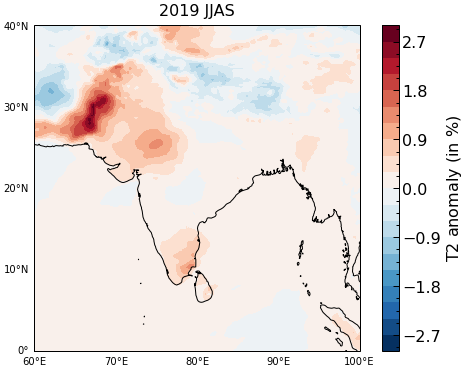

In [40]:
plot(d2m_anomaly.sel(time=slice("2019-06-01 09:00:00","2019-09-30 23:00:00")).mean(dim='time'), extent_list=[59.9, 100.1, -0.1, 40.1], title='2019 JJAS', levels=20, cmap='RdBu_r', cbar_kwargs={'label':'T2 anomaly (in $\%$)'})

In [52]:
# plt.figure(figsize=(15,4))
# t2m_anomaly.sel(time=slice("2019-06-01 09:00:00","2019-06-30 23:00:00")).mean(dim=['lat', 'lon']).plot()
# plt.savefig('./images/test.pdf', dpi=300)

## testing quantreg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [2]:
rng = np.random.RandomState(42)

In [3]:
x = np.linspace(0, 10, 2000)
X = x[:, np.newaxis]

In [4]:
X.shape

(2000, 1)

In [5]:
y_true_mean = 10 + 0.5 * x

In [6]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

In [7]:
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

In [8]:
y_pareto.shape

(2000,)

In [9]:
qr = QuantileRegressor(quantile=0.99, alpha=0)

In [10]:
qr5 = QuantileRegressor(quantile=0.50, alpha=0)

In [11]:
y_pred = qr.fit(X, y_normal).predict(X)

In [21]:
y_pred5 = qr5.fit(X, y_normal).predict(X)

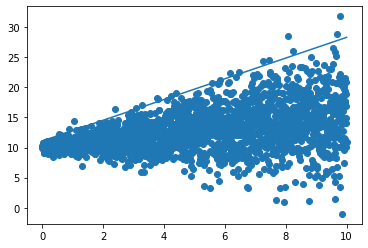

In [12]:
plt.plot(x, y_pred)
# plt.plot(x, y_pred5)
plt.scatter(x, y_normal)